In [1]:
import os
import geopandas as gp
import pandas as pd
import maup
wd = os.getcwd()
data_fold= os.path.join(wd,'raw-from-source')
export_fold = os.path.join(wd,'EXPORTS')
if not os.path.exists(export_fold):
    os.mkdir(export_fold)

# Katy_ISD_2016_2020_Elections_Demographics_12_09_2022

## Background:
- We received a request for election data from the 2020 Democratic primary for U.S. Senate in Texas and 2016 presidential general election at 2020 block and 2022 precinct level in the Katy Independent School District.

## Approach:
- Use 2016 disaggregated election data at the block level 
- Disaggregate 2020 primary data from 2020 precincts to 2020 block using the [maup library](https://github.com/mggg/maup)
- Query demographic data from Public Law 94-171 data and aggregate race categories as needed (e.g. any part Black)
- Join all 2020 block level data together
- Assign 2020 blocks to school districts in Texas using maup and query for just those in Katy ISD
- Aggregate block level data to the 2022 precincts inside Katy ISD using maup
- Clip precincts to Katy ISD


## Links to datasets used:
- [Texas 2022 Primary Election Voting Precincts Shapefile](https://data.capitol.texas.gov/dataset/precincts/resource/fb56da88-63d5-44a9-9577-63d1b654a8ab)
- [Texas 2022 School Districts](https://data.capitol.texas.gov/dataset/school-districts)
- [2016 Texas General Election Results Disaggregated to 2020 Census Blocks](https://redistrictingdatahub.org/dataset/2016-texas-general-election-results-disaggregated-to-2020-census-blocks/)
- [Texas block group PL 94-171 2020](https://redistrictingdatahub.org/dataset/texas-block-group-pl-94171-2020/)
- [Texas State boundaries (2020)](https://redistrictingdatahub.org/dataset/texas-state-boundaries-2020/)
- [Texas 2020 General and Primary VTD Boundary and Election Results](https://redistrictingdatahub.org/dataset/texas-2020-general-and-primary-vtd-boundary-and-election-results/)
- [KISD_Polling_Locations-2023.pdf](https://www.katyisd.org/cms/lib/TX50010808/Centricity/domain/4308/documents/election_23/KISD_Polling_Locations-2023.pdf)

For a full 'raw-from-source' file, contact info@redistrictingdatahub.org

Read in 2022 Precinct shapefile and query to the list of precincts in the KISD_Polling_Locations-2023.pdf

In [2]:
vtd_file = gp.read_file(os.path.join(data_fold,'Precincts22P_20220518.shp'))
vtd = vtd_file[vtd_file['CNTY'].isin([201,157,473])]
vtd['PRECINCT22'] = vtd.apply(lambda x: str(x['CNTY']) + '-' + x['PREC'],axis=1)
#481571148
new_vals = ['157-1038', '157-1142', '157-1144', '157-1122', '157-1130', '157-1145', '157-1014', '157-1156', '201-0639', '473-0420', '201-0119', '201-0121', '201-0331', '201-0624', '201-0991', '201-1086', '473-0314', '473-0418', '201-0362', '201-0619', '201-0644', '201-0509', '201-0522', '201-0547', '201-0751', '201-1054', '201-1111', '201-1112', '201-0095', '201-0461', '201-0711', '201-0860', '201-0603', '201-0618', '201-0720', '201-0731', '201-0785', '201-0796', '201-0813', '201-0877', '201-1078', '201-1102', '201-1103', '201-1120', '201-0463', '201-0521', '201-0589', '201-0804', '201-0879', '201-0992', '201-1042', '201-1072', '201-1123', '201-0398', '201-0523', '201-0621', '201-0650', '201-1059', '201-0400', '201-0772', '201-0802', '201-0899', '201-1029', '157-1006', '157-1143', '157-1146', '157-1148', '157-1159', '157-1004', '157-1132', '157-1133', '157-1160']
precs = vtd[vtd['PRECINCT22'].isin(new_vals)]
precs.head(1)

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,CNTY,COLOR,PREC,PCTKEY,cntykey,Shape_area,Shape_len,geometry,PRECINCT22
2199,157,1,1145,1571145,79,2.930497e+06,9464.927039,"POLYGON ((1407497.756 849479.492, 1407522.291 ...",157-1145


Create dictionaries for matching precincts to Katy ISD Districts and polling locations and add as columns to the precinct file based on info form the KISD_Polling_Locations-2023.pdf

In [3]:
katy_dict = {'157-1038': '1', '157-1142': '1', '157-1144': '1', '157-1122': '2', '157-1130': '2', '157-1145': '2', '157-1014': '3', '157-1156': '3', '201-0639': '3', '473-0420': '3', '201-0119': '4', '201-0121': '4', '201-0331': '4', '201-0624': '4', '201-0991': '4', '201-1086': '4', '473-0314': '4', '473-0418': '4', '201-0362': '5', '201-0619': '5', '201-0644': '5', '201-0509': '6', '201-0522': '6', '201-0547': '6', '201-0751': '6', '201-1054': '6', '201-1111': '6', '201-1112': '6', '201-0095': '7', '201-0461': '7', '201-0711': '7', '201-0860': '7', '201-0603': '8', '201-0618': '8', '201-0720': '8', '201-0731': '8', '201-0785': '8', '201-0796': '8', '201-0813': '8', '201-0877': '8', '201-1078': '8', '201-1102': '8', '201-1103': '8', '201-1120': '8', '201-0463': '9', '201-0521': '9', '201-0589': '9', '201-0804': '9', '201-0879': '9', '201-0992': '9', '201-1042': '9', '201-1072': '9', '201-1123': '9', '201-0398': '10', '201-0523': '10', '201-0621': '10', '201-0650': '10', '201-1059': '10', '201-0400': '11', '201-0772': '11', '201-0802': '11', '201-0899': '11', '201-1029': '11', '157-1006': '12', '157-1143': '12', '157-1146': '12', '157-1148': '12', '157-1159': '12', '157-1004': '13', '157-1132': '13', '157-1133': '13', '157-1160': '13'}
polling_dict = {'1':'Seven Lakes High School','2':'Cinco Ranch High School','3':'Katy City Hall','4':'Katy Municipal Court Building','5':'Memorial Parkway Junior High','6':'Taylor High School','7':'Maurice Wolfe Elementary','8':'Morton Ranch High School','9':'Mayde Creek Junior High','10':'Bear Creek Elementary','11':'Pattison Elementary','12':'Jordan High School','13':'Beck Junior High'}

precs['KATY_DIST']=precs['PRECINCT22'].apply(lambda x: katy_dict.get(x))
precs['POLL_LOC']=precs['KATY_DIST'].apply(lambda x: polling_dict.get(x))
precs['PRECINCT22'] = precs['PRECINCT22'].apply(lambda x: '48'+str(x).replace('-',''))
precs = precs[['PRECINCT22','KATY_DIST','POLL_LOC','geometry']].copy(deep=True)
#Get CRS of the precinct file
crs= precs.crs
precs.head(1)

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,PRECINCT22,KATY_DIST,POLL_LOC,geometry
2199,481571145,2,Cinco Ranch High School,"POLYGON ((1407497.756 849479.492, 1407522.291 ..."


Read in 2016 block-level election data and query out desired columns

In [4]:
elec16 = gp.read_file(os.path.join(os.path.join(data_fold,'tx_2016_gen_2020_blocks'),'tx_2016_gen_2020_blocks.shp'))
elec16_sub = elec16[elec16['COUNTYFP'].isin(['201','157','473'])]
elec16_sub = elec16_sub[['GEOID20','VAP_MOD','G16PRERTRU','G16PREDCLI','geometry']]
elec16_sub.head(1)

,GEOID20,VAP_MOD,G16PRERTRU,G16PREDCLI,geometry
234233,481576701011000,47,3.0,9.74,"POLYGON ((-95.46504 29.59960, -95.46024 29.597..."


Read in block-level demographic data from the Census Pl 94-171 file and query out and aggregate fields of interest

In [5]:
tx_b = pd.read_csv(os.path.join(os.path.join(data_fold,'tx_pl2020_b'),'tx_pl2020_b.csv'))
tx_sub = tx_b[tx_b['COUNTY'].isin([201,157,473])]
any_part_black_fields = ['P0030004','P0030011','P0030016','P0030017','P0030018','P0030019','P0030027','P0030028','P0030029','P0030030','P0030037','P0030038','P0030039','P0030040','P0030041','P0030042','P0030048','P0030049','P0030050','P0030051','P0030052','P0030053','P0030058','P0030059','P0030060','P0030061','P0030064','P0030065','P0030066','P0030067','P0030069','P0030071']
hispanic_field = ['P0040002']
white_field = ['P0040005']
total_vap = ['P0030001']
total_pop = ['P0010001']
tx_sub['VAPMOD20'] = tx_sub['P0030001']-tx_sub['P0050003']
tx_sub['VAPMOD20'] = tx_sub['VAPMOD20'].apply(lambda x: 0 if x<0 else x)
tx_sub['APBVAP20'] = tx_sub[any_part_black_fields].sum(axis=1)
col_to_keep = ['GEOCODE']+total_pop+total_vap+['VAPMOD20']+['APBVAP20']+hispanic_field+white_field
b = tx_sub[col_to_keep]
rename_dict = {'GEOCODE':'GEOID20','P0010001':'TOTPOP20','P0040002':'HVAP20','P0040005':'WVAP20','P0030001':'VAP20'}
b.rename(columns = rename_dict,inplace=True)
b.head(1)

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_1232\608401889.py:1: DtypeWarning: Columns (29,31,37,38,55) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_b = pd.read_csv(os.path.join(os.path.join(data_fold,'tx_pl2020_b'),'tx_pl2020_b.csv'))
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_1232\608401889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_sub['VAPMOD20'] = tx_sub['P0030001']-tx_sub['P0050003']
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_1232\608401889.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,GEOID20,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20
234233,481576701011000,62,47,47,3,38,6


Join block-level election results and demographic data together

In [6]:
elec16_sub['GEOID20'] = elec16_sub['GEOID20'].astype(str)
b['GEOID20'] = b['GEOID20'].astype(str)
b_joined = pd.merge(elec16_sub, b, on ='GEOID20',how='outer',indicator=True)
display(b_joined[b_joined['_merge']!='both'])
b_joined.drop(columns = '_merge',inplace=True)
b_joined = b_joined[['GEOID20', 'TOTPOP20', 'VAP20', 'VAPMOD20', 'APBVAP20', 'HVAP20', 'WVAP20','G16PRERTRU', 'G16PREDCLI', 'geometry']]
b_joined.head(1)

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_1232\1828396079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['GEOID20'] = b['GEOID20'].astype(str)


,GEOID20,VAP_MOD,G16PRERTRU,G16PREDCLI,geometry,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20,_merge


,GEOID20,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20,G16PRERTRU,G16PREDCLI,geometry
0,481576701011000,62,47,47,3,38,6,3.0,9.74,"POLYGON ((-95.46504 29.59960, -95.46024 29.597..."


Read in school district boundaries and query out Katy ISD

In [7]:
tx_schools = gp.read_file(os.path.join(data_fold,'SchoolDistricts_SY2122.shp'))
tx_schools = tx_schools[['NAME20','geometry']]
katy_bound = tx_schools[tx_schools['NAME20'].str.contains('Katy')]
katy_bound = katy_bound.to_crs(crs)
katy_bound.head(1)

,NAME20,geometry
709,Katy Independent School District,"POLYGON ((1407156.153 869955.347, 1407247.654 ..."


Read in Texas state boundary file and create a geodataframe of Katy ISD and the rest of Texas boundaries to use for maup to ensure data is properly assigned

,NAME20,geometry
0,Texas,"POLYGON ((624768.847 1098969.672, 624791.653 1..."
709,Katy Independent School District,"POLYGON ((1407156.153 869955.347, 1407247.654 ..."


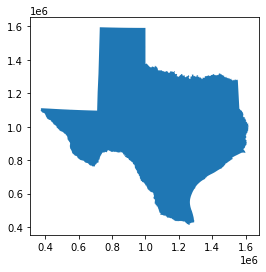

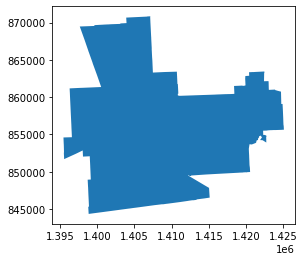

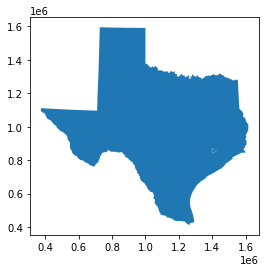

In [8]:
tx_bound = gp.read_file(os.path.join(os.path.join(data_fold,'tx_st_2020_bound'),'tx_st_2020_bound.shp'))
tx_bound = tx_bound.to_crs(crs)
tx_bound = tx_bound[['geometry']]
tx_no_katy = gp.overlay(tx_bound,katy_bound, how='symmetric_difference')
tx_no_katy['NAME20']='Texas'
tx_katy = gp.GeoDataFrame(pd.concat([tx_no_katy,katy_bound]))
tx_katy = tx_katy[['NAME20','geometry']]
tx_bound.plot()
katy_bound.plot()
tx_katy.plot()
tx_katy

Read in 2020 primary election data and query out election columns of interest and assign blocks to 2020 VTDS

In [9]:
vtd20 = gp.read_file(os.path.join(data_fold,'tx_20_st_vtd.shp'))
vtd20 = vtd20[['UNIQUE_ID','P20USSDHEG','P20USSDWES','geometry']]

vtd20 = vtd20.to_crs(crs)
b_joined = b_joined.to_crs(crs)
tx_katy = tx_katy.to_crs(crs)

vtd20_block_assign = maup.assign(b_joined,vtd20)
vtd20['VAPMOD20'] = b_joined['VAPMOD20'].groupby(vtd20_block_assign).sum()
vtd20['VAPMOD20'] = vtd20['VAPMOD20'].fillna(-1)
vtd20_sub = vtd20[vtd20['VAPMOD20']>-1]

vtd20_sub.head(1)

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\maup\indexed_geometries.py:15: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometry.index = i


,UNIQUE_ID,P20USSDHEG,P20USSDWES,geometry,VAPMOD20
1570,157-1001,61,14,"POLYGON ((1411714.880 832683.163, 1411608.596 ...",2569.0


Disaggregate 2020 election data to 2020 blocks

In [10]:
elec20_cols = ['P20USSDHEG','P20USSDWES']
weights = b_joined.VAPMOD20/vtd20_block_assign.map(vtd20_sub.VAPMOD20)
b_joined[elec20_cols] = maup.prorate(vtd20_block_assign,vtd20_sub[elec20_cols],weights)
for i in elec20_cols:
    b_joined[i] = b_joined[i].apply(lambda x: round(x,2))
b_joined.head(1)

,GEOID20,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20,G16PRERTRU,G16PREDCLI,geometry,P20USSDHEG,P20USSDWES
0,481576701011000,62,47,47,3,38,6,3.0,9.74,"POLYGON ((1438415.407 835611.315, 1438890.023 ...",0.24,0.13


Query out blocks that are just in Katy ISD

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_1232\686454537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blocks_in_katy.drop(columns = 'SD',inplace=True)


,GEOID20,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20,G16PRERTRU,G16PREDCLI,geometry,P20USSDHEG,P20USSDWES
GEOID20,,,,,,,,,,,,
481576729022000,481576729022000,0,0,0,0,0,0,0.0,0.0,"POLYGON ((1410309.468 845871.115, 1410358.149 ...",0.0,0.0


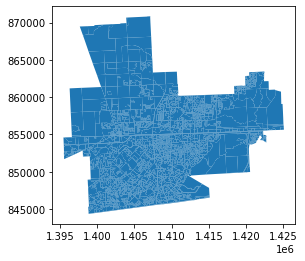

In [11]:
b_joined_for_maup = b_joined.copy(deep=True)
b_joined_for_maup.set_index('GEOID20',drop=False,inplace=True)
tx_katy_maup = tx_katy.copy(deep=True)
tx_katy_maup.set_index('NAME20',inplace=True,drop=False)
b_joined_for_maup['SD'] = maup.assign(b_joined_for_maup,tx_katy_maup)
blocks_in_katy = b_joined_for_maup[b_joined_for_maup['SD'].str.contains('Katy')]
blocks_in_katy.drop(columns = 'SD',inplace=True)

blocks_in_katy.plot()
blocks_in_katy.head(1)

Clip 2022 precincts to Katy ISD

<AxesSubplot:>

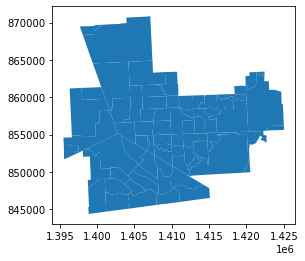

In [12]:
precs_clip = gp.clip(precs,katy_bound,keep_geom_type=True)
precs_clip
precs_clip.plot()

Assign precincts, polling lications, and Katy ISD Districts to blocks 

In [13]:
precs_clip_maup = precs_clip.copy(deep=True)
precs_clip_maup.set_index('PRECINCT22',drop=False,inplace=True)

blocks_in_katy['PRECINCT22'] = maup.assign(blocks_in_katy,precs_clip_maup)

blocks_in_katy['PRECINCT22'] = blocks_in_katy['PRECINCT22'].astype(str)
blocks_in_katy['PRECINCT_HOLD'] = blocks_in_katy['PRECINCT22'].apply(lambda x: str(x).replace('48157','157-'))#201,473
blocks_in_katy['PRECINCT_HOLD'] = blocks_in_katy['PRECINCT_HOLD'].apply(lambda x: str(x).replace('48201','201-'))
blocks_in_katy['PRECINCT_HOLD'] = blocks_in_katy['PRECINCT_HOLD'].apply(lambda x: str(x).replace('48473','473-'))

blocks_in_katy['KATY_DIST']=blocks_in_katy['PRECINCT_HOLD'].apply(lambda x: katy_dict.get(x))
blocks_in_katy['POLL_LOC']=blocks_in_katy['KATY_DIST'].apply(lambda x: polling_dict.get(x))

null_blocks = blocks_in_katy[blocks_in_katy['PRECINCT22'].str.contains('nan')]
null_block_geoids = list(null_blocks['GEOID20'])
blocks_in_katy = blocks_in_katy[~blocks_in_katy['GEOID20'].isin(null_block_geoids)]

blocks_in_katy.drop(columns = 'PRECINCT_HOLD',inplace=True)
blocks_in_katy.reset_index(inplace=True,drop=True)

blocks_in_katy = blocks_in_katy[['GEOID20','PRECINCT22','KATY_DIST','POLL_LOC','TOTPOP20','VAP20','VAPMOD20','APBVAP20','HVAP20','WVAP20','G16PRERTRU','G16PREDCLI','P20USSDHEG','P20USSDWES','geometry']]

for i in ['G16PRERTRU','G16PREDCLI','P20USSDHEG','P20USSDWES']:
    blocks_in_katy[i] = blocks_in_katy[i].fillna(0.0)

blocks_in_katy

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,GEOID20,PRECINCT22,KATY_DIST,POLL_LOC,TOTPOP20,VAP20,VAPMOD20,APBVAP20,HVAP20,WVAP20,G16PRERTRU,G16PREDCLI,P20USSDHEG,P20USSDWES,geometry
0,481576729022000,481571132,13,Beck Junior High,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1410309.468 845871.115, 1410358.149 ..."
1,481576729023000,481571132,13,Beck Junior High,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1410059.083 845841.123, 1410120.359 ..."
2,481576729023001,481571132,13,Beck Junior High,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1409454.382 845758.680, 1409466.519 ..."
3,481576729023010,481571132,13,Beck Junior High,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1408947.323 845693.630, 1409285.445 ..."
4,481576729023011,481571132,13,Beck Junior High,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1408615.813 845676.622, 1408704.234 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,484736801002132,484730420,3,Katy City Hall,48,24,24,0,3,11,6.23,1.13,0.00,0.0,"POLYGON ((1397529.315 852881.294, 1397731.728 ..."
3463,484736801002133,484730420,3,Katy City Hall,28,12,12,1,2,5,3.11,0.57,0.00,0.0,"POLYGON ((1397522.379 852808.180, 1397532.407 ..."
3464,484736801002134,484730420,3,Katy City Hall,63,42,42,0,10,31,10.90,1.98,0.61,0.4,"POLYGON ((1401993.188 856342.331, 1402001.998 ..."
3465,484736801002135,484730420,3,Katy City Hall,0,0,0,0,0,0,0.00,0.00,0.00,0.0,"POLYGON ((1397795.961 852823.356, 1397942.875 ..."


Export block level data

In [14]:
blocks_in_katy.to_file(os.path.join(export_fold,'katy_isd_2016_2020_elec_2020_demo_2020_b.shp'))

Assign blocks to clipped precincts and aggregate block data to 2022 precincts

<AxesSubplot:>

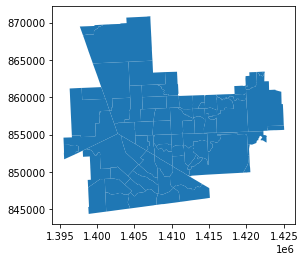

In [15]:
prec_assign = maup.assign(blocks_in_katy, precs_clip) 
variables = ['TOTPOP20', 'VAP20', 'VAPMOD20', 'APBVAP20', 'HVAP20', 'WVAP20', 'G16PRERTRU', 'G16PREDCLI', 'P20USSDHEG', 'P20USSDWES']
precs_clip[variables] = blocks_in_katy[variables].groupby(prec_assign).sum()
precs_clip_cols = list(precs_clip.columns)
precs_clip_cols.remove('geometry')
precs_clip_cols.append('geometry')
precs_clip = precs_clip[precs_clip_cols]
precs_clip = precs_clip.dissolve('PRECINCT22')
precs_clip.reset_index(inplace=True,drop=False)
precs_clip = precs_clip[['PRECINCT22','KATY_DIST','POLL_LOC','TOTPOP20', 'VAP20', 'VAPMOD20', 'APBVAP20', 'HVAP20', 'WVAP20', 'G16PRERTRU', 'G16PREDCLI', 'P20USSDHEG', 'P20USSDWES','geometry']]
precs_clip.head()
precs_clip.plot()

Export precinct level data

In [16]:
precs_clip.to_file(os.path.join(export_fold,'katy_isd_2016_2020_elec_2020_demo_2022_prec.shp'))